In [2]:
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
np.set_printoptions(precision=4)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
DATADIR = 'data/'

In [5]:
def read_corpus(file):
    """
    returns:
        lines: [['hello', 'world'], ...]
        labels: [[!], [N], ...]
        vocab
    """
    with open(file, 'rt') as f:
        text = f.read()
    lines = text.split('\n\n')
    ret_lines = []
    labels = []
    vocab = set()
    for line in lines:
        if not line: 
            continue
        curr_line = []
        for token_label_str in line.split('\n'):
            if not token_label_str: 
                continue
            token, label = token_label_str.split('\t')
            vocab.add(token)
            labels.append(label)
            curr_line.append(token)
        ret_lines.append(curr_line)
    return ret_lines, labels, vocab

In [6]:
def encode_lines(lines, word2idx_map, window_size):
    """
    returns X: len(lines) x (2 * window_size + 1)
    """
    def encode_line(line, word2idx_map, window_size):
        num_repr = [] # numerical representation
        for word in line:
            num = word2idx_map.get(word, word2idx_map['UUUNKKK'])
            num_repr.append(num)
        # pad with start and end tokens
        start = [word2idx_map['<s>']] * window_size
        end = [word2idx_map['</s>']] * window_size
        padded = start + num_repr + end
        
        ret = []
        for i in range(window_size, len(padded) - window_size):
            windowed = padded[i - window_size : i + window_size + 1]
            ret.append(windowed)
            
        return ret
    
    res = []
    for line in lines:
        res.extend(encode_line(line, word2idx_map, window_size))
    return torch.tensor(res)

# Network

In [7]:
class FeedForwardTagger(nn.Module):
    
    def __init__(self, vocab_size, window_size, output_dim,
                 emb_dim=50, pretrained_emb=None, freeze=False):
        super(FeedForwardTagger, self).__init__()
        if pretrained_emb:
            self.emb = nn.Embedding.from_pretrained(pretrain_emb)
        else:
            self.emb = nn.Embedding(vocab_size, emb_dim)
            torch.nn.init.uniform_(self.emb.weight, -0.01, 0.01)
        input_dim = (2 * window_size + 1) * emb_dim
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, inputs):
        embeds = self.emb(inputs).view((inputs.shape[0], -1))
        out = torch.tanh(self.fc1(embeds))
        out = self.fc2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [19]:
def train_util(model, X_train, Y_train, X_dev, Y_dev, n_epochs, lr, 
              batch_size):
    """
    returns: best_model, losses, train_accu_list, dev_accu_list
    """
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    best_model = None
    best_dev_accu = 0
    losses = []
    train_accu_list, dev_accu_list = [], []
    for epoch in range(n_epochs):
        epoch_loss = 0
        
        for i in range(0, X_train.shape[0], batch_size):
            optimizer.zero_grad()
            log_probs = model(X_train[i : i + batch_size])
            loss = loss_func(log_probs, Y_train[i : i + batch_size])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        train_preds = torch.argmax(model(X_train), dim=1)
        train_accu = accuracy_score(Y_train, train_preds)
        # evaluate on dev
        dev_preds = torch.argmax(model(X_dev), dim=1)
        dev_accu = accuracy_score(Y_dev, dev_preds)
        
        # early stopping, save the model if it has improved on dev
        if dev_accu > best_dev_accu:
            best_dev_accu = dev_accu
            best_model = deepcopy(model)
        
        print('Epoch {}: loss {:.4f}, train_accu: {:.4f}, dev_accu: {:.4f}'\
              .format(epoch, epoch_loss, train_accu, dev_accu))
        losses.append(epoch_loss)
        train_accu_list.append(train_accu)
        dev_accu_list.append(dev_accu)
        
    return best_model, losses, train_accu_list, dev_accu_list

# Load Data

In [9]:
train, train_labels, train_vocab = read_corpus(DATADIR + 'twpos-train.tsv')
dev, dev_labels, dev_vocab = read_corpus(DATADIR + 'twpos-dev.tsv')
devtest, devtest_labels, devtest_vocab = read_corpus(DATADIR + 'twpos-devtest.tsv')

In [57]:
all_labels = np.unique(train_labels)
all_labels_devtest = np.unique(devtest_labels) # devtest labels

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
Y_train = label_encoder.transform(train_labels)
Y_dev = label_encoder.transform(dev_labels)
Y_devtest = label_encoder.transform(devtest_labels)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_dev = torch.tensor(Y_dev, dtype=torch.long)
Y_devtest = torch.tensor(Y_devtest, dtype=torch.long)

In [55]:
# devtest labels
all_labels_devtest = np.unique(devtest_labels)

array(['!', '#', '$', '&', ',', '@', 'A', 'D', 'E', 'G', 'L', 'N', 'O',
       'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Z', '^', '~'], dtype='<U1')

In [11]:
vocab = train_vocab.copy()
vocab.update(dev_vocab)
vocab.update(devtest_vocab)

# 1. Baseline w/ Randomly Initialized Embeddings

In [12]:
# construct maps for randomly initialized embs
idx2word_rand = sorted(vocab)
idx2word_rand += ['<s>', '</s>', 'UUUNKKK']
word2idx_rand = {word: idx for idx, word in enumerate(idx2word_rand)}

## Encode Train, Dev, DevTest

In [13]:
# w = 0
X_train_w0 = encode_lines(train, word2idx_rand, window_size=0)
X_dev_w0 = encode_lines(dev, word2idx_rand, window_size=0)
X_devtest_w0 = encode_lines(devtest, word2idx_rand, window_size=0)

In [14]:
# w = 1
X_train_w1 = encode_lines(train, word2idx_rand, window_size=1)
X_dev_w1 = encode_lines(dev, word2idx_rand, window_size=1)
X_devtest_w1 = encode_lines(devtest, word2idx_rand, window_size=1)

## Train Model

### w = 0

In [58]:
model_w0 = FeedForwardTagger(vocab_size=len(word2idx_rand), 
                          window_size=0,
                          output_dim=len(all_labels))
best_model_w0, losses_w0, train_accu_w0, dev_accu_w0 = \
train_util(model_w0, X_train_w0, Y_train, X_dev_w0, Y_dev, n_epochs=20,
              lr=2, batch_size=1000)

Epoch 0: loss 49.3563, train_accu: 0.1172, dev_accu: 0.1037
Epoch 1: loss 42.0999, train_accu: 0.4511, dev_accu: 0.4453
Epoch 2: loss 31.8247, train_accu: 0.5380, dev_accu: 0.5306
Epoch 3: loss 26.5072, train_accu: 0.5897, dev_accu: 0.5787
Epoch 4: loss 23.4432, train_accu: 0.6310, dev_accu: 0.6192
Epoch 5: loss 20.5444, train_accu: 0.6637, dev_accu: 0.6455
Epoch 6: loss 18.0283, train_accu: 0.6834, dev_accu: 0.6604
Epoch 7: loss 15.8725, train_accu: 0.7327, dev_accu: 0.6887
Epoch 8: loss 13.9496, train_accu: 0.7795, dev_accu: 0.7156
Epoch 9: loss 12.2609, train_accu: 0.8200, dev_accu: 0.7270
Epoch 10: loss 10.8345, train_accu: 0.8339, dev_accu: 0.7343
Epoch 11: loss 9.7204, train_accu: 0.8524, dev_accu: 0.7413
Epoch 12: loss 8.8058, train_accu: 0.8588, dev_accu: 0.7488
Epoch 13: loss 8.0767, train_accu: 0.8703, dev_accu: 0.7507
Epoch 14: loss 7.4375, train_accu: 0.8899, dev_accu: 0.7606
Epoch 15: loss 6.9247, train_accu: 0.8975, dev_accu: 0.7615
Epoch 16: loss 6.5259, train_accu: 0.90

In [59]:
# evaluate on devtest
devtest_preds = torch.argmax(best_model_w0(X_devtest_w0), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w0 = confusion_matrix(Y_devtest, devtest_preds)
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.7728


### w = 1

In [24]:
model_w1 = FeedForwardTagger(vocab_size=len(word2idx_rand), 
                          window_size=1,
                          output_dim=len(all_labels))
best_model_w1, losses_w1, train_accu_w1, dev_accu_w1 = \
train_util(model_w1, X_train_w1, Y_train, X_dev_w1, Y_dev, n_epochs=20,
              lr=2, batch_size=1000)

Epoch 0: loss 49.8925, train_accu: 0.1172, dev_accu: 0.1037
Epoch 1: loss 45.1811, train_accu: 0.2403, dev_accu: 0.2282
Epoch 2: loss 35.1940, train_accu: 0.5627, dev_accu: 0.5507
Epoch 3: loss 25.8895, train_accu: 0.6166, dev_accu: 0.6051
Epoch 4: loss 21.6122, train_accu: 0.6564, dev_accu: 0.6434
Epoch 5: loss 18.6827, train_accu: 0.7004, dev_accu: 0.6756
Epoch 6: loss 16.1544, train_accu: 0.7363, dev_accu: 0.7042
Epoch 7: loss 14.0722, train_accu: 0.7761, dev_accu: 0.7291
Epoch 8: loss 12.2682, train_accu: 0.8099, dev_accu: 0.7457
Epoch 9: loss 10.6924, train_accu: 0.8361, dev_accu: 0.7590
Epoch 10: loss 9.3295, train_accu: 0.8589, dev_accu: 0.7695
Epoch 11: loss 8.1653, train_accu: 0.8771, dev_accu: 0.7778
Epoch 12: loss 7.1885, train_accu: 0.8928, dev_accu: 0.7878
Epoch 13: loss 6.3810, train_accu: 0.9053, dev_accu: 0.7928
Epoch 14: loss 5.7107, train_accu: 0.9142, dev_accu: 0.8005
Epoch 15: loss 5.1442, train_accu: 0.9210, dev_accu: 0.8029
Epoch 16: loss 4.6587, train_accu: 0.927

In [49]:
devtest_preds = torch.argmax(best_model_w1(X_devtest_w1), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w1 = confusion_matrix(Y_devtest, devtest_preds)
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8209


## Plot losses and accuracy, and confusion matrix

In [44]:
w0_df = pd.DataFrame({'epoch': range(len(losses_w0)), 
                      'loss': losses_w0, 
                      'train_accu': train_accu_w0,
                     'dev_accu': dev_accu_w0})
w1_df = pd.DataFrame({'epoch': range(len(losses_w1)), 
                      'loss': losses_w1, 
                      'train_accu': train_accu_w1,
                     'dev_accu': dev_accu_w1})
plot_df = pd.concat([
    w0_df.melt('epoch', value_vars=['loss']).assign(window=0, plot='loss'),
    w0_df.melt('epoch', value_vars=['train_accu', 'dev_accu']).assign(window=0, plot='accu'),
    w1_df.melt('epoch', value_vars=['loss']).assign(window=1, plot='loss'),
    w1_df.melt('epoch', value_vars=['train_accu', 'dev_accu']).assign(window=1, plot='accu')
])

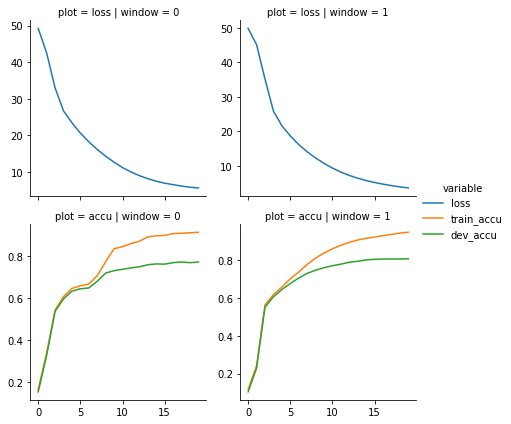

In [46]:
g = sns.FacetGrid(data=plot_df, row='plot', col='window', 
                  hue='variable', sharey=False)
g.map_dataframe(sns.lineplot, x='epoch', y='value')
g.add_legend()

### w=0

Text(0.5, 1.0, 'w=0')

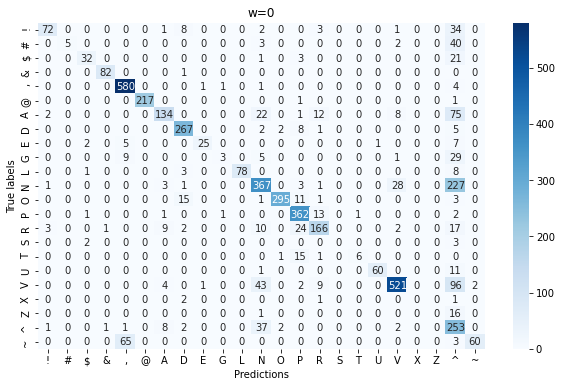

In [73]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(conf_matrix_w0, xticklabels=all_labels_devtest, 
                 yticklabels=all_labels_devtest, annot=True, 
                 fmt='d', cmap='Blues')
ax.set_xlabel('Predictions')
ax.set_ylabel('True labels')
ax.set_title('w=0')

### w=1

Text(0.5, 1.0, 'w=1')

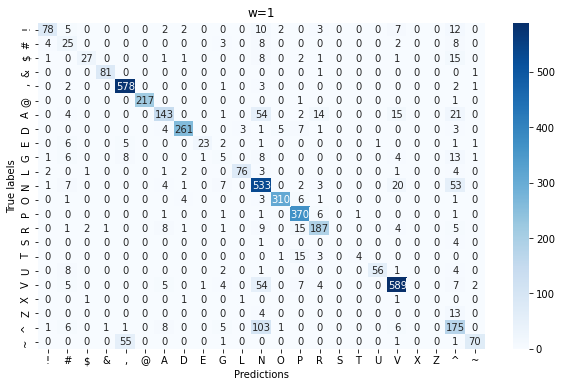

In [72]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(conf_matrix_w1, xticklabels=all_labels_devtest, 
                 yticklabels=all_labels_devtest, annot=True, 
                 fmt='d', cmap='Blues')
ax.set_xlabel('Predictions')
ax.set_ylabel('True labels')
ax.set_title('w=1')

## Error analysis

# 2. Feature Engineering

In [54]:
conf_matrix_w0.shape

(23, 23)

# 3. Pretrained Embeddings

In [ ]:
# construct maps for pretrained word embs

# 4. Architecture Engineering
## w = 2

In [ ]:
# w = 2
X_train_w2 = encode_lines(train, word2idx_rand, window_size=2)
X_dev_w2 = encode_lines(dev, word2idx_rand, window_size=2)
X_devtest_w2 = encode_lines(devtest, word2idx_rand, window_size=2)